In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from itertools import combinations
from sklearn.model_selection import train_test_split

%config InlineBackend.figure_format="retina"

In [2]:
SEC_IN_HOUR = 3600

In [3]:
def rmse(y_true, y_pred):
    from sklearn.metrics import mean_squared_error

    return np.sqrt(mean_squared_error(y_true, y_pred))


def prediction_scatter_plot(y_true, y_pred):
    max_value = int(max(y_true.max(), y_pred.max()))
    min_value = int(min(y_true.min(), y_pred.min()))

    sns.scatterplot(x=y_true, y=y_pred, alpha=0.4)
    sns.lineplot(
        x=[min_value, max_value], 
        y=[min_value, max_value], 
        color="darkred")
    
    plt.xlabel("True time")
    plt.ylabel("Predicted time")
    plt.show()

# Load data

In [4]:
orders = pd.read_csv("data/orders.csv")
print("N rows:", orders.shape[0])
orders.head()

N rows: 5000


,Id,running_time,completed_time,route_distance_km,delta_time
0,-4773019581999572651,2022-01-24 18:30:21,2022-01-24 18:44:43,3.740,862.0
1,-7575630690398473489,2022-01-24 06:53:53,2022-01-24 07:06:26,3.526,753.0
2,-6264582368520213833,2022-01-24 10:00:59,2022-01-24 10:15:58,5.071,899.0
3,5964315354301636538,2022-01-24 14:28:05,2022-01-24 14:35:08,2.867,423.0
4,1372379574816145639,2022-01-24 11:57:29,2022-01-24 12:06:29,3.751,540.0


In [5]:
nodes = pd.read_csv("data/nodes.csv")
print("N rows:", nodes.shape[0])
nodes.head()

N rows: 480291


,Id,node_start,node_finish,distance,speed
0,-2627062893189810184,10980432,2133368107,17.414917,32.0
1,-2627062893189810184,10980433,5212387954,17.186539,26.0
2,-2627062893189810184,10980445,5221700954,28.513481,26.0
3,-2627062893189810184,10980498,10980445,154.266122,25.0
4,-2627062893189810184,10980647,1986137911,8.542824,29.0


## Clean data

### Review `data types` and presense of `missing values`

In [6]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Id                 5000 non-null   int64  
 1   running_time       5000 non-null   object 
 2   completed_time     5000 non-null   object 
 3   route_distance_km  5000 non-null   float64
 4   delta_time         5000 non-null   float64
dtypes: float64(2), int64(1), object(2)
memory usage: 195.4+ KB


In [7]:
nodes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480291 entries, 0 to 480290
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Id           480291 non-null  int64  
 1   node_start   480291 non-null  int64  
 2   node_finish  480291 non-null  int64  
 3   distance     480291 non-null  float64
 4   speed        476307 non-null  float64
dtypes: float64(2), int64(3)
memory usage: 18.3 MB


In [8]:
n_speed_nulls = nodes.speed.isna().sum()
n_speed_nulls_pct = round(n_speed_nulls / nodes.speed.size * 100, 3)
print(f"Only 'speed' columns has Null values - {n_speed_nulls} records or {n_speed_nulls_pct}% of all records")

Only 'speed' columns has Null values - 3984 records or 0.829% of all records


Scince there are only less that 1% of missing values for 'speed' column, it would be ok to drop them whatsoever. But then we wouldn't be able to make predictions during inference in case speed data were missing. So it will be better to populate missing values with some type of average value for the speed.

### Fix dates

In [9]:
orders["running_time"] = pd.to_datetime(orders.running_time)
orders["completed_time"] = pd.to_datetime(orders.completed_time)
orders["delta_time"] = orders.delta_time.astype(int)

Test `delta_time` is eques to `completed_time` - `running_time`.

In [10]:
((orders.completed_time - orders.running_time).dt.seconds == orders.delta_time).all()

True

Now that we confirmed `delta_time` values are consistent with dates, let's drop `completed_time`, since we won't have it at prediction time and we already have `delta_time` for training.

In [11]:
orders = orders.drop(columns="completed_time")
orders.head(3)

,Id,running_time,route_distance_km,delta_time
0,-4773019581999572651,2022-01-24 18:30:21,3.740,862
1,-7575630690398473489,2022-01-24 06:53:53,3.526,753
2,-6264582368520213833,2022-01-24 10:00:59,5.071,899


## Review distributions of rides data

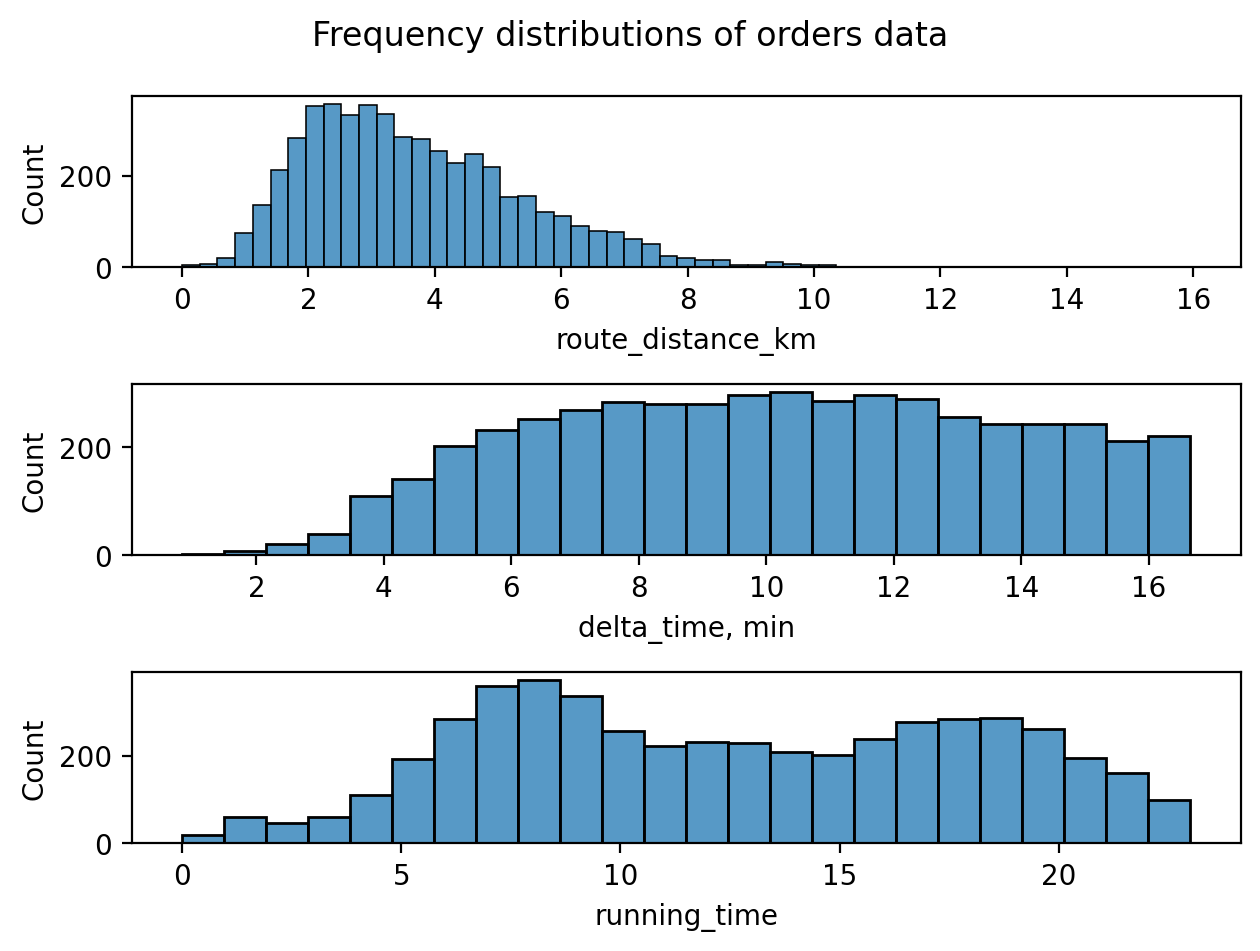

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)

sns.histplot(orders["route_distance_km"], ax=ax1)
sns.histplot(orders["delta_time"]/60, ax=ax2)
sns.histplot(orders["running_time"].dt.hour, bins=24, ax=ax3)

ax2.set(xlabel="delta_time, min")

plt.suptitle("Frequency distributions of orders data")
plt.tight_layout()
plt.show()

Overall data are evenly distributed. Though it might be reasonable to cap `route_distance_km` at 10km. Also there is expected pattern of `running_time`, with peaks of taxi rides in the morning and in the evening.

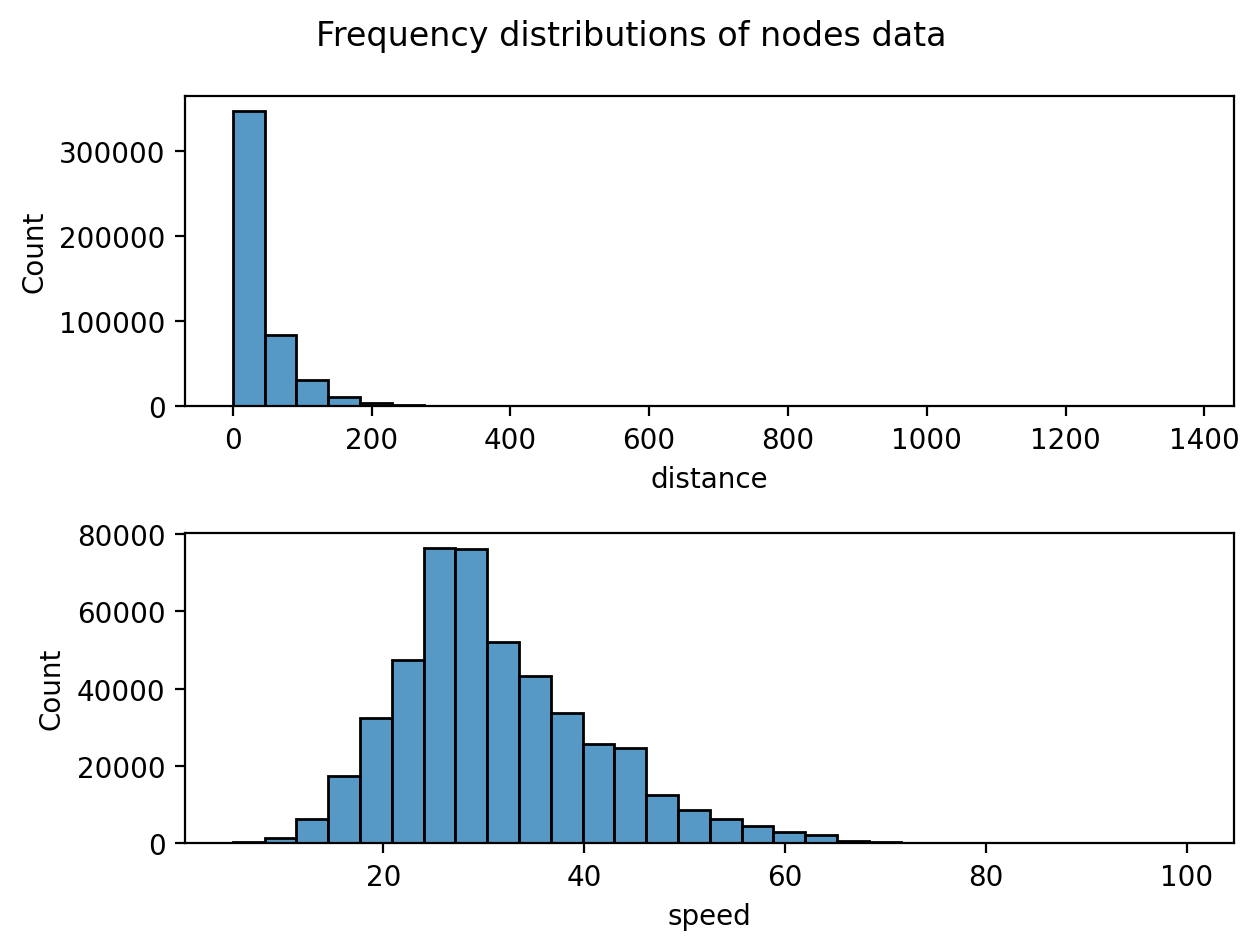

In [13]:
fig, (ax1, ax2) = plt.subplots(2, 1)

sns.histplot(nodes["distance"], bins=30, ax=ax1)
sns.histplot(nodes["speed"], bins=30, ax=ax2)

plt.suptitle("Frequency distributions of nodes data")
plt.tight_layout()
plt.show()

## Populate missing values for `speed` column

In [14]:
nodes.speed.isna().sum()

3984

In [15]:
median_speed = nodes.speed.median()
nodes["speed"] = nodes.speed.fillna(median_speed)
nodes.speed.isna().sum()

0

In [16]:
median_speed

30.0

# Baseling model

In [17]:
orders = orders.set_index("Id")
orders = orders.sort_index()

Let's test first what we can get with arithmetics)

In [18]:
print("orders")
display(orders[:2])
print("nodes")
display(nodes[:2])

orders


,running_time,route_distance_km,delta_time
Id,,,
-9220688251826578095,2022-01-24 23:22:55,3.179,469
-9218029690111550526,2022-01-24 20:55:10,6.137,688


nodes


,Id,node_start,node_finish,distance,speed
0,-2627062893189810184,10980432,2133368107,17.414917,32.0
1,-2627062893189810184,10980433,5212387954,17.186539,26.0


In [19]:
print(orders.index.unique().size, "- number of unique Id's in orders")
print(nodes.Id.unique().size, "- number of unique Id's in nodes")

5000 - number of unique Id's in orders
6000 - number of unique Id's in nodes


1000 of Id's in `nodes` reserved for test set.

## Test sum of `distance`s == `route_distance_km`

In [20]:
nodes["node_distance_km"] = nodes["distance"] / 1000

In [21]:
orders["estimated_distance_km"] = nodes.groupby("Id")["node_distance_km"].sum()

In [22]:
abs_dist_error = orders.route_distance_km - orders.estimated_distance_km
pct_dist_error = abs_dist_error / orders.route_distance_km

In [23]:
orders[["route_distance_km", "estimated_distance_km"]][abs_dist_error.abs() > 5]

,route_distance_km,estimated_distance_km
Id,,
-8394093829256565742,9.345,3.290647
-8002220901714339319,9.541,3.853165
-6027585925853831217,10.385,4.341672
-4918959035330405933,6.456,0.994772
-3112411208152921432,6.120,0.801031
-2974225395988514712,13.974,0.840535
-2348829635281343628,7.752,0.309966
-2163636109012931382,8.515,3.230139
-2114841861158971913,13.445,1.189584


In [24]:
pct_dist_error[pct_dist_error < -1]

Id
-1192707391945981694     -2.089400
 501553711430980009      -8.547448
 2095549082118522788    -34.287977
 3937754682929437166          -inf
 6614642619573540328     -2.089548
 7967605010530440667   -127.402182
 8249534331247000992   -459.407841
 8785249738865542814     -1.516763
 9009307819813040657     -1.851401
dtype: float64

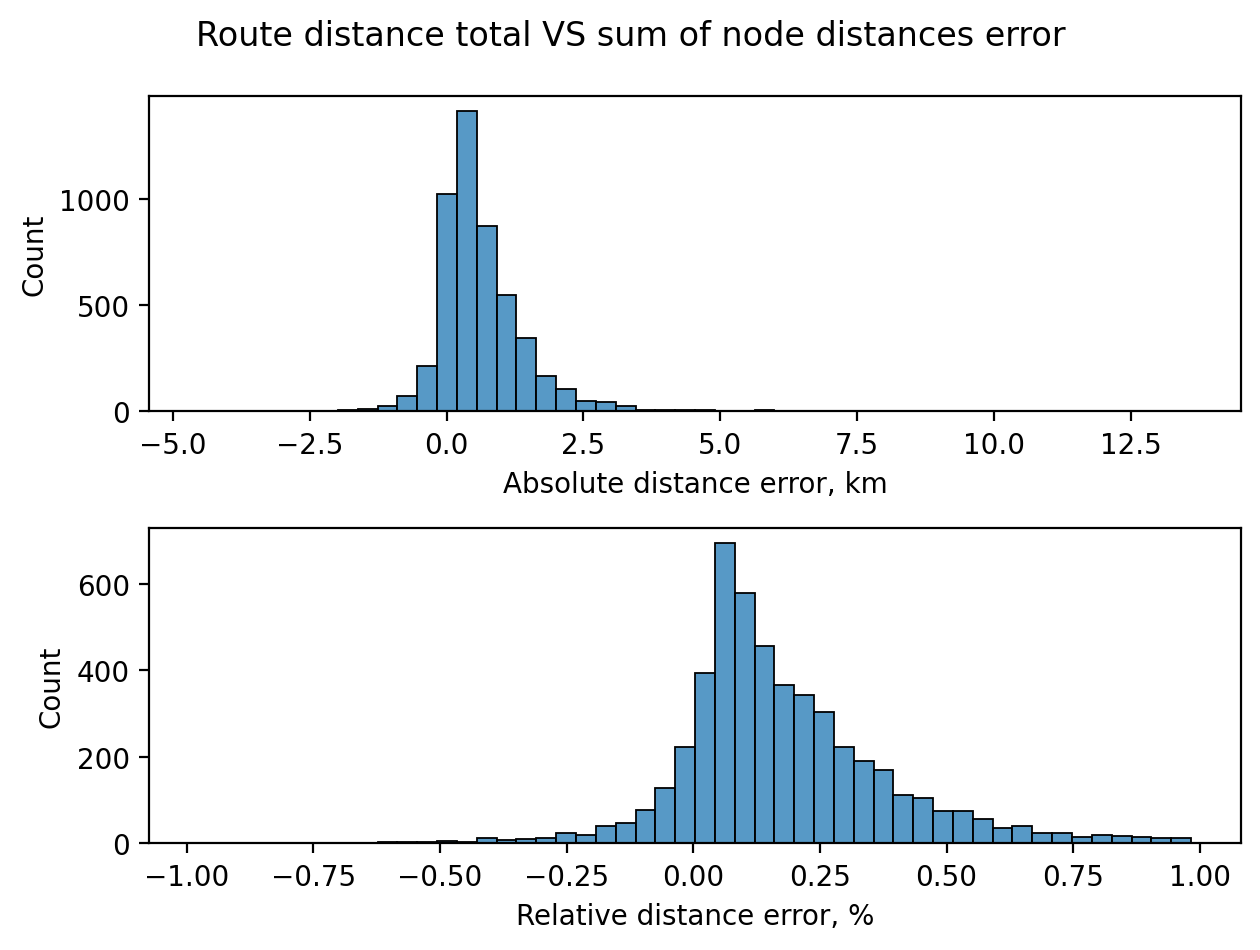

In [25]:
fig, (ax1, ax2) = plt.subplots(2, 1)

sns.histplot(abs_dist_error, bins=50, ax=ax1)
sns.histplot(pct_dist_error[pct_dist_error > -1], bins=50, ax=ax2)

plt.suptitle("Route distance total VS sum of node distances error")
ax1.set(xlabel="Absolute distance error, km")
ax2.set(xlabel="Relative distance error, %")
plt.tight_layout()
plt.show()

## 'Arithmeric' model

In [26]:
orders[:2]

,running_time,route_distance_km,delta_time,estimated_distance_km
Id,,,,
-9220688251826578095,2022-01-24 23:22:55,3.179,469,3.002769
-9218029690111550526,2022-01-24 20:55:10,6.137,688,5.629672


In [27]:
nodes[:2]

,Id,node_start,node_finish,distance,speed,node_distance_km
0,-2627062893189810184,10980432,2133368107,17.414917,32.0,0.017415
1,-2627062893189810184,10980433,5212387954,17.186539,26.0,0.017187


In [28]:

estimated_delta = nodes.groupby('Id').apply(lambda g: (g["node_distance_km"] / g["speed"]).sum() * SEC_IN_HOUR)

In [29]:
orders["estimated_delta"] = estimated_delta
orders.shape

(5000, 5)

In [30]:
orders[:6]

,running_time,route_distance_km,delta_time,estimated_distance_km,estimated_delta
Id,,,,,
-9220688251826578095,2022-01-24 23:22:55,3.179,469,3.002769,436.960531
-9218029690111550526,2022-01-24 20:55:10,6.137,688,5.629672,665.599521
-9203204462098983368,2022-01-24 22:38:37,6.312,683,5.598777,606.449872
-9183832189489697758,2022-01-24 22:20:25,6.379,885,5.041412,540.833285
-9182793427449706037,2022-01-24 17:25:48,2.551,612,2.428830,418.166930
-9166192455403663250,2022-01-24 22:11:01,1.722,231,1.749998,147.606350


In [31]:
rmse(orders.delta_time, orders.estimated_delta)

287.75303022269

In [32]:
estim_error = orders.delta_time - orders.estimated_delta

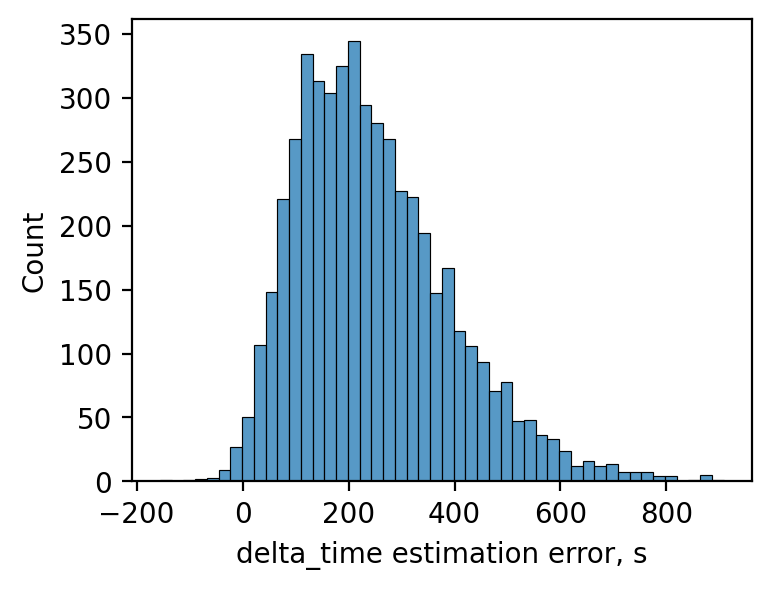

In [33]:
plt.figure(figsize=(4, 3))
sns.histplot(estim_error)
plt.xlabel("delta_time estimation error, s")
plt.show()

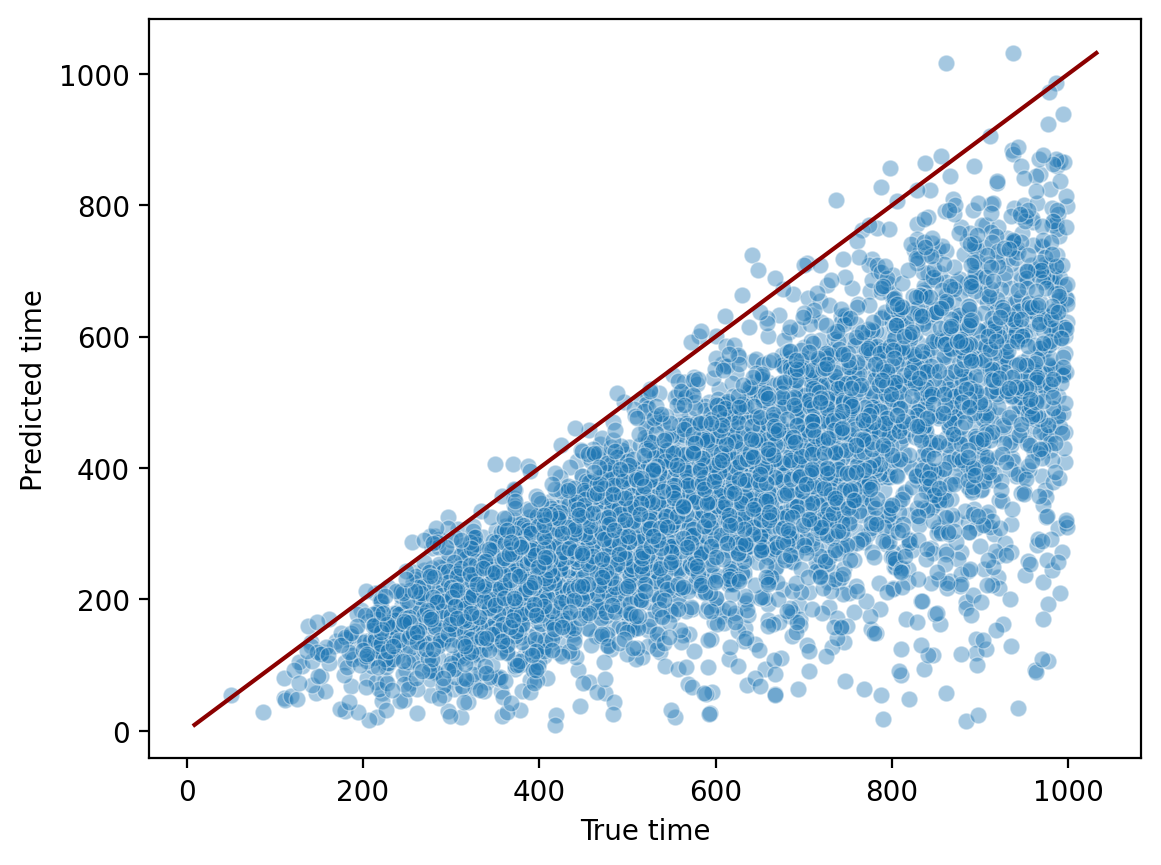

In [34]:
prediction_scatter_plot(orders.delta_time, orders.estimated_delta)

# Linear regression

In [35]:
from sklearn.linear_model import LinearRegression

In [36]:
train_orders, val_orders  = train_test_split(orders, train_size=0.8, random_state=43)

In [37]:
x_train, y_train = train_orders["estimated_delta"], train_orders["delta_time"]
x_val, y_val = val_orders["estimated_delta"], val_orders["delta_time"]

x_train = x_train.values.reshape(-1, 1)
x_val = x_val.values.reshape(-1, 1)

In [38]:
reg = LinearRegression(n_jobs=-1)
reg.fit(x_train, y_train)

LinearRegression(n_jobs=-1)

In [39]:
reg.coef_, reg.intercept_

(array([0.93412658]), 272.58246150507983)

In [40]:
y_pred = reg.predict(x_val)
rmse(y_val, y_pred)

143.5945891165553

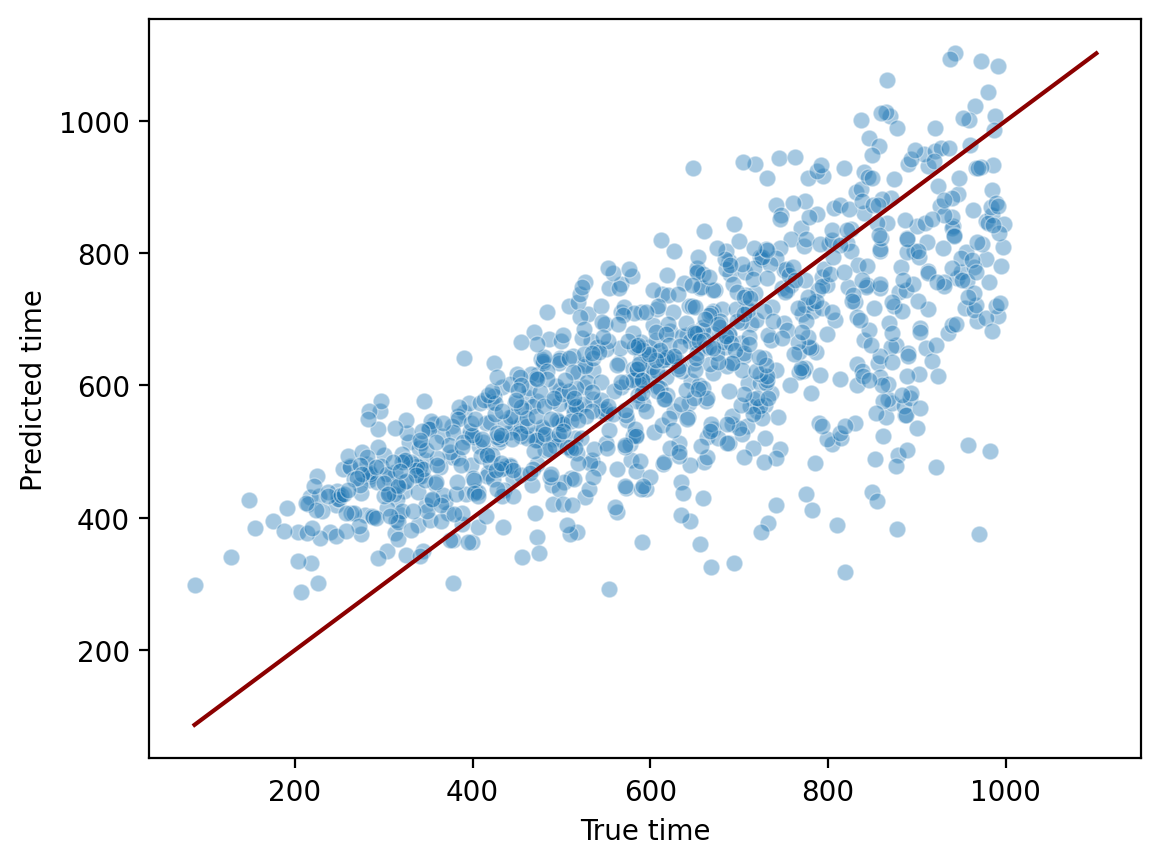

In [41]:
prediction_scatter_plot(y_val, y_pred)

# Feature engineering

In [42]:
orders["running_hour"] = orders.running_time.dt.hour

In [43]:
orders["distance_error"] = orders["route_distance_km"] - orders["estimated_distance_km"]
orders["distance_error_sqr"] = np.square(orders["distance_error"])

In [44]:
orders[:3]

,running_time,route_distance_km,delta_time,estimated_distance_km,estimated_delta,running_hour,distance_error,distance_error_sqr
Id,,,,,,,,
-9220688251826578095,2022-01-24 23:22:55,3.179,469,3.002769,436.960531,23,0.176231,0.031057
-9218029690111550526,2022-01-24 20:55:10,6.137,688,5.629672,665.599521,20,0.507328,0.257382
-9203204462098983368,2022-01-24 22:38:37,6.312,683,5.598777,606.449872,22,0.713223,0.508687


In [45]:
nodes[:3]

,Id,node_start,node_finish,distance,speed,node_distance_km
0,-2627062893189810184,10980432,2133368107,17.414917,32.0,0.017415
1,-2627062893189810184,10980433,5212387954,17.186539,26.0,0.017187
2,-2627062893189810184,10980445,5221700954,28.513481,26.0,0.028513


In [46]:
TARGET_COL = "delta_time"
FEATURE_COLS = ["estimated_delta", "route_distance_km", "running_hour", "estimated_distance_km", "distance_error", "distance_error_sqr"]

In [47]:
results = []

train_orders, val_orders  = train_test_split(orders, train_size=0.8, random_state=43)

for n_features in range(1, len(FEATURE_COLS) + 1):
    for features in combinations(FEATURE_COLS, n_features):
        features = list(features)
        
        if n_features == 1:
            features = features[0]

        x_train, y_train = train_orders[features], train_orders[TARGET_COL]
        x_val, y_val = val_orders[features], val_orders[TARGET_COL]

        if n_features == 1:
            x_train = x_train.values.reshape(-1, 1)
            x_val = x_val.values.reshape(-1, 1)

        reg = LinearRegression(n_jobs=-1)
        reg.fit(x_train, y_train)

        y_pred = reg.predict(x_val)

        results.append([rmse(y_val, y_pred), features])

In [48]:
for result in sorted(results, key=lambda x: x[0])[:10]:
    print(*result)

125.56477963521094 ['estimated_delta', 'running_hour', 'estimated_distance_km', 'distance_error', 'distance_error_sqr']
125.56477963521095 ['estimated_delta', 'route_distance_km', 'running_hour', 'distance_error', 'distance_error_sqr']
125.56477963521097 ['estimated_delta', 'route_distance_km', 'running_hour', 'estimated_distance_km', 'distance_error_sqr']
125.56477963521097 ['estimated_delta', 'route_distance_km', 'running_hour', 'estimated_distance_km', 'distance_error', 'distance_error_sqr']
126.3888211127749 ['estimated_delta', 'route_distance_km', 'running_hour', 'distance_error']
126.3888211127749 ['estimated_delta', 'running_hour', 'estimated_distance_km', 'distance_error']
126.38882111277493 ['estimated_delta', 'route_distance_km', 'running_hour', 'estimated_distance_km']
126.38882111277496 ['estimated_delta', 'route_distance_km', 'running_hour', 'estimated_distance_km', 'distance_error']
126.53416622193362 ['estimated_delta', 'route_distance_km', 'estimated_distance_km', 'dist

## GradientBoostingRegressor

In [49]:
from sklearn.ensemble import GradientBoostingRegressor

In [50]:

train_orders, val_orders  = train_test_split(orders, train_size=0.8, random_state=43)

x_train, y_train = train_orders[FEATURE_COLS], train_orders[TARGET_COL]
x_val, y_val = val_orders[FEATURE_COLS], val_orders[TARGET_COL]

reg = GradientBoostingRegressor()
reg.fit(x_train, y_train)

y_pred = reg.predict(x_val)

rmse(y_val, y_pred)

114.48346504681034

In [51]:
results = []

train_orders, val_orders  = train_test_split(orders, train_size=0.8, random_state=43)

for n_features in range(1, len(FEATURE_COLS) + 1):
    for features in combinations(FEATURE_COLS, n_features):
        features = list(features)
        
        if n_features == 1:
            features = features[0]

        x_train, y_train = train_orders[features], train_orders[TARGET_COL]
        x_val, y_val = val_orders[features], val_orders[TARGET_COL]

        if n_features == 1:
            x_train = x_train.values.reshape(-1, 1)
            x_val = x_val.values.reshape(-1, 1)

        reg = GradientBoostingRegressor()
        reg.fit(x_train, y_train)

        y_pred = reg.predict(x_val)

        results.append([rmse(y_val, y_pred), features])

In [52]:
for result in sorted(results, key=lambda x: x[0])[:10]:
    print(*result)

113.99816963781542 ['estimated_delta', 'running_hour', 'estimated_distance_km', 'distance_error', 'distance_error_sqr']
114.01186128773936 ['estimated_delta', 'route_distance_km', 'running_hour', 'estimated_distance_km', 'distance_error_sqr']
114.18799415421734 ['estimated_delta', 'running_hour', 'distance_error', 'distance_error_sqr']
114.34580718989312 ['estimated_delta', 'route_distance_km', 'running_hour', 'distance_error_sqr']
114.36724484336824 ['estimated_delta', 'running_hour', 'distance_error']
114.38078281386473 ['estimated_delta', 'route_distance_km', 'running_hour', 'estimated_distance_km', 'distance_error', 'distance_error_sqr']
114.49478540617919 ['estimated_delta', 'running_hour', 'estimated_distance_km', 'distance_error']
114.57813727284451 ['estimated_delta', 'route_distance_km', 'running_hour', 'distance_error', 'distance_error_sqr']
114.62795230416494 ['estimated_delta', 'route_distance_km', 'running_hour', 'distance_error']
114.6630603474977 ['estimated_delta', 'run